# 1. Introduction and Dataset Overview


**Dataset Name**: Real or Fake Job Posting Prediction

**Source**: Kaggle (https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data)

**Purpose**: To predict whether a job posting is real or fake.

**Problem Type**: Binary Classification

**Target Variable**: fraudulent (1: Fake, 0: Real)

**Key Features**: 

* **title:** Job title.
* **location:** Job location.
* **description:** Job description.
* **requirements:** Job requirements.
* **benefits:** Job benefits.
* **telecommuting:** Whether the job is telecommuting.
* **has_company_logo:** Whether the company has a logo.
* **has_questions:** Whether the job has screening questions.
* **employment_type:** Type of employment.
* **required_experience:** Required experience.
* **required_education:** Required education.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from nltk.corpus import stopwords
from category_encoders import TargetEncoder

In [2]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

## 1.1 Loading the dataset

In [3]:
try:
    file_path = os.path.join("data", "fake_job_postings.csv")
    df = pd.read_csv(file_path)  # Load from local file
except FileNotFoundError:
    # If the file is not found locally, attempt to load it from the Kaggle URL. 
    print("Error: 'fake_job_postings.csv' not found in the 'data' directory. Please download it from Kaggle and place it in the same directory as this script.")
    df = None # set df to None to prevent further errors
    exit()

## 1.2 Checking for target class distribution 

In [4]:
# Check for balanced or imbalanced class distribution
print("\nClass Distribution:")
print(df['fraudulent'].value_counts())
print(f"\nProportion of Fake Postings: {df['fraudulent'].mean():.4f}")


Class Distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64

Proportion of Fake Postings: 0.0484


# 2. Data Preprocessing and Cleaning

In [5]:
df.head()


job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

## 2.1 Dropping unwanted columns

In [7]:
unwanted_columns = ['job_id','location','salary_range', 'department'] 
df = df.drop(columns=unwanted_columns, errors='ignore')
print("\nAfter Dropping Unwanted Columns:")
df.head()


After Dropping Unwanted Columns:


title  \
0                           Marketing Intern   
1  Customer Service - Cloud Video Production   
2    Commissioning Machinery Assistant (CMA)   
3          Account Executive - Washington DC   
4                        Bill Review Manager   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

## 2.2 Handling Missing Data

In [8]:
print("\nMissing Data Before Handling:")
df.isnull().sum()


Missing Data Before Handling:


title                     0
company_profile        3308
description               1
requirements           2696
benefits               7212
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [9]:
# Impute missing text data with "Missing"
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [10]:
# Impute categorical features with the mode
categorical_columns = ['employment_type', 'required_education', 'required_experience', 'function', 'industry']
for col in categorical_columns:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

In [11]:
# Impute numerical features with the median
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('fraudulent') 
if numerical_cols: 
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [12]:
print("\nMissing Data After Handling:")
print(df.isnull().sum())


Missing Data After Handling:
title                  0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


## 2.3 Handling Outliers

In [13]:
numerical_cols

['telecommuting', 'has_company_logo', 'has_questions']

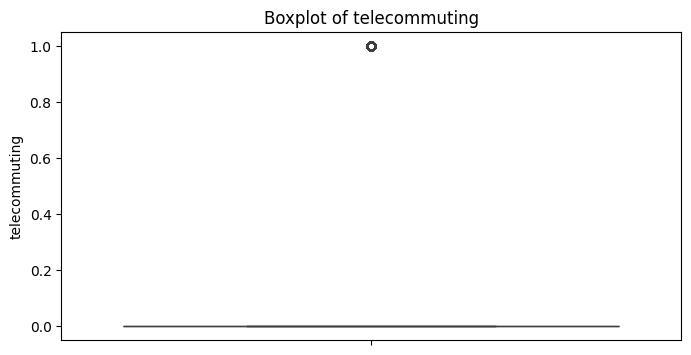

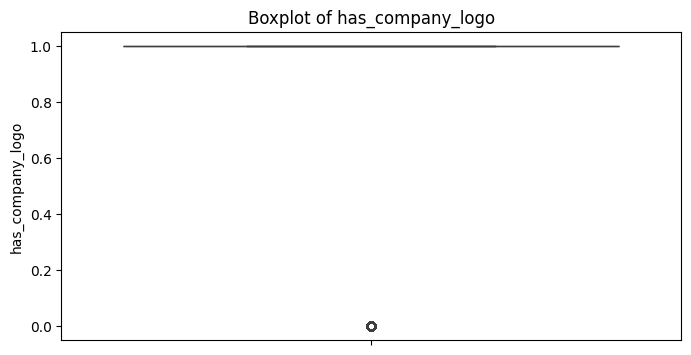

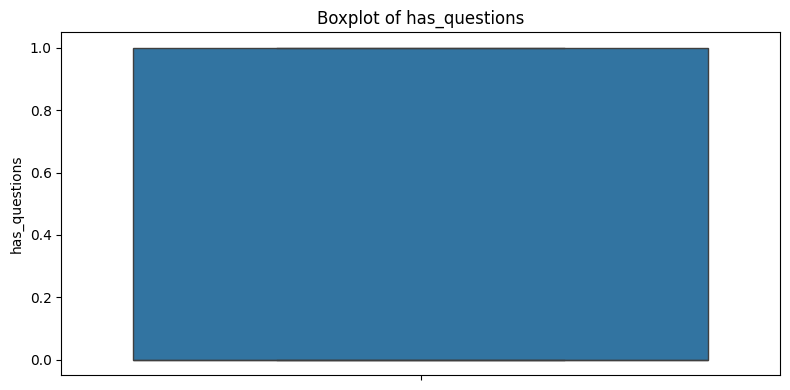

In [14]:
for i, col in enumerate(numerical_cols):
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [15]:
df_no_target = df[numerical_cols]
z_scores = zscore(df_no_target)
abs_z_scores = np.abs(z_scores)
filtering_mask = (abs_z_scores < 3).all(axis=1) 
print(f"Shape after outlier removal: {df.shape}")


Shape after outlier removal: (17880, 14)


In [16]:
for col in categorical_columns:
    print(f"{df[col].value_counts()}\n")

employment_type
Full-time    15091
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

required_education
Bachelor's Degree                    13250
High School or equivalent             2080
Unspecified                           1397
Master's Degree                        416
Associate Degree                       274
Certification                          170
Some College Coursework Completed      102
Professional                            74
Vocational                              49
Some High School Coursework             27
Doctorate                               26
Vocational - HS Diploma                  9
Vocational - Degree                      6
Name: count, dtype: int64

required_experience
Mid-Senior level    10859
Entry level          2697
Associate            2297
Not Applicable       1116
Director              389
Internship            381
Executive             141
Name: count, dtype: int64

function
Information Technol

# 3. Exploratory Data Analysis (EDA)

## 3.1 Descriptive Statistics

In [17]:
numerical_desc = df.describe()
numerical_desc

telecommuting  has_company_logo  has_questions    fraudulent
count   17880.000000      17880.000000   17880.000000  17880.000000
mean        0.042897          0.795302       0.491723      0.048434
std         0.202631          0.403492       0.499945      0.214688
min         0.000000          0.000000       0.000000      0.000000
25%         0.000000          1.000000       0.000000      0.000000
50%         0.000000          1.000000       0.000000      0.000000
75%         0.000000          1.000000       1.000000      0.000000
max         1.000000          1.000000       1.000000      1.000000

In [18]:
categorical_desc = df.describe(exclude=np.number)
categorical_desc

title company_profile  \
count                     17880           17880   
unique                    11231            1710   
top     English Teacher Abroad          Missing   
freq                        311            3308   

                                              description requirements  \
count                                               17880        17880   
unique                                              14802        11966   
top     Play with kids, get paid for it Love travel? J...      Missing   
freq                                                  379         2696   

       benefits employment_type required_experience required_education  \
count     17880           17880               17880              17880   
unique     6204               5                   7                 13   
top     Missing       Full-time    Mid-Senior level  Bachelor's Degree   
freq       7212           15091               10859              13250   

                                   industry                function  
count                                 17880                   17880  
unique                                  131                      37  
top     Information Technology and Services  Information Technology  
freq                                   6637                    8204

## 3.2 Correlation Analysis

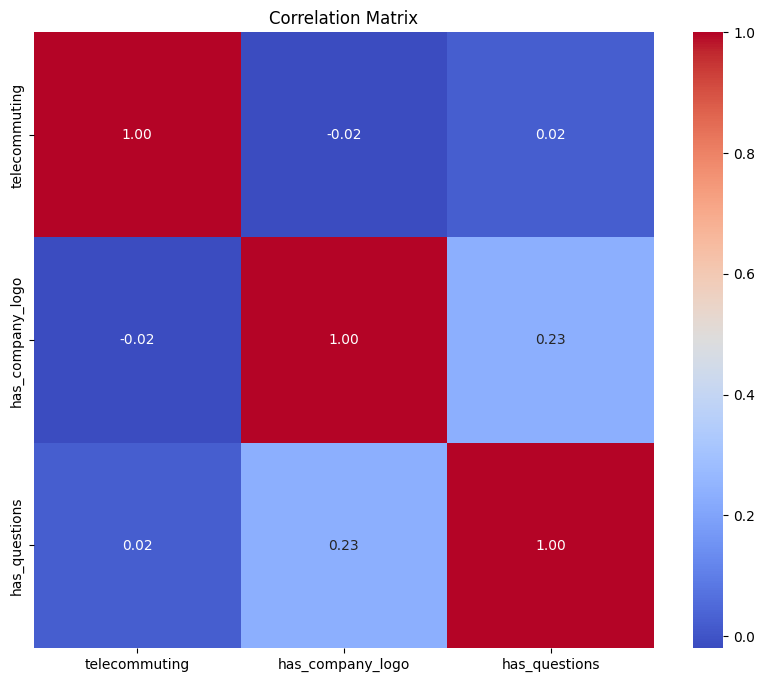

In [19]:
# Calculate correlation matrix
cor_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 3.3 Visualizations

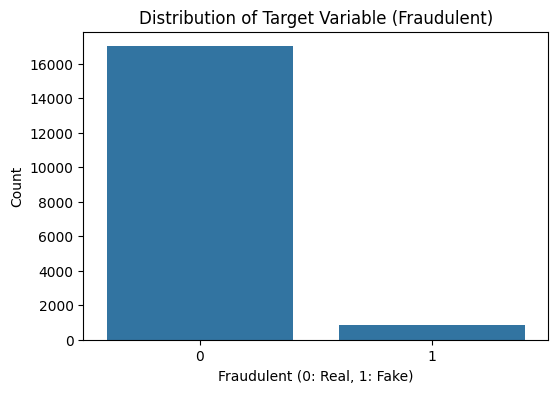

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Target Variable (Fraudulent)')
plt.xlabel('Fraudulent (0: Real, 1: Fake)')
plt.ylabel('Count')
plt.show()

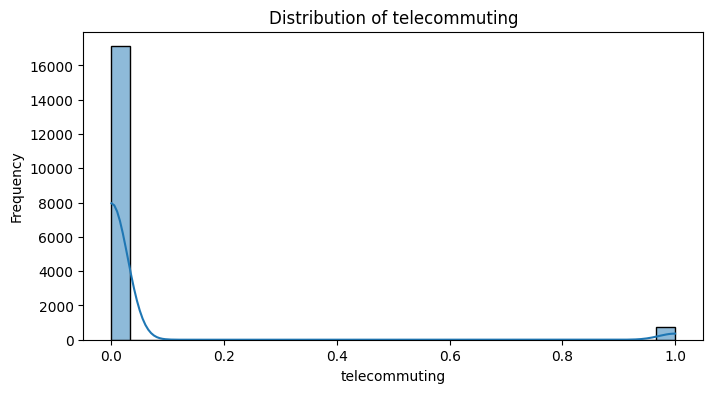

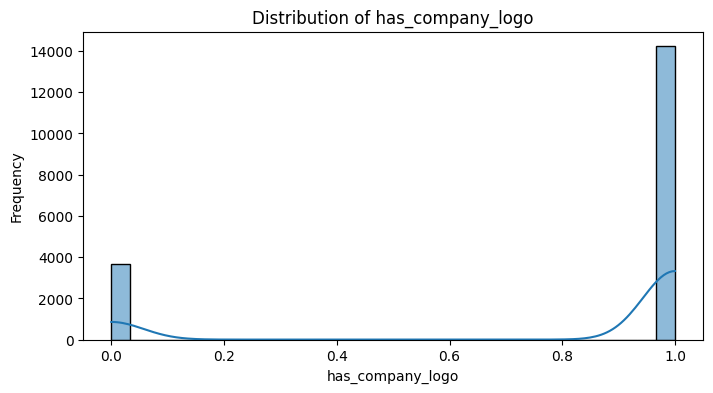

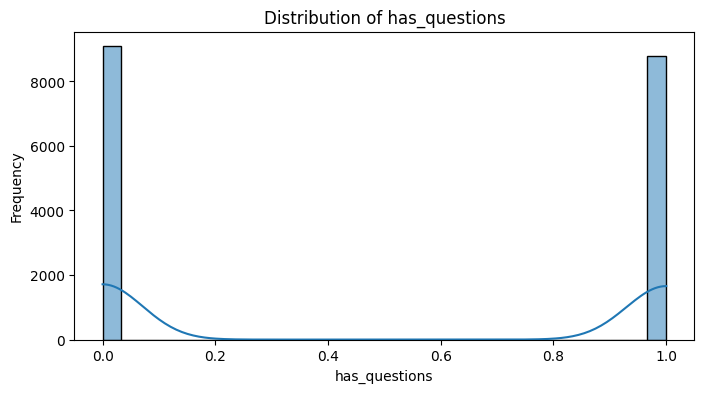

In [21]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

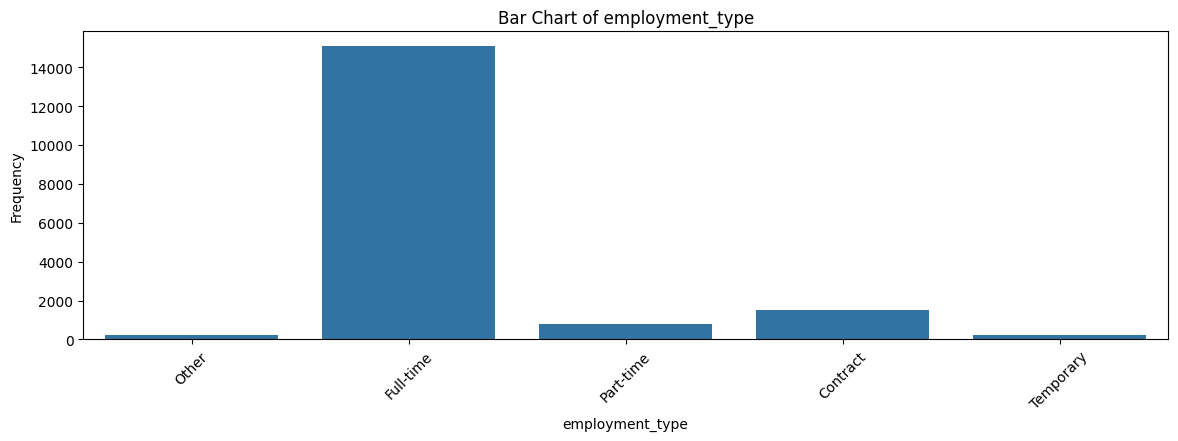

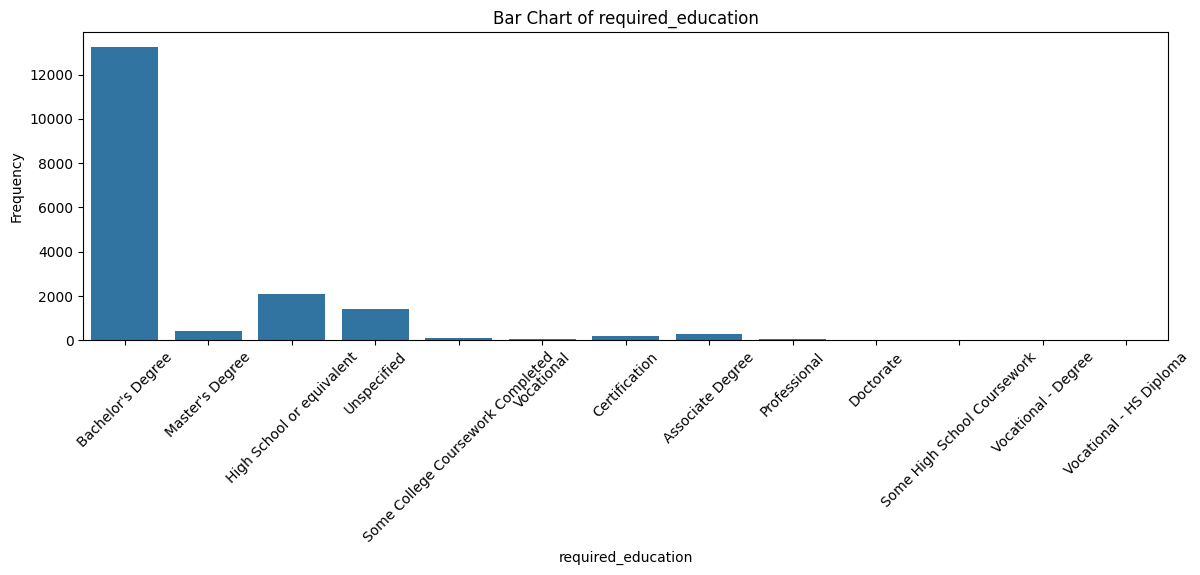

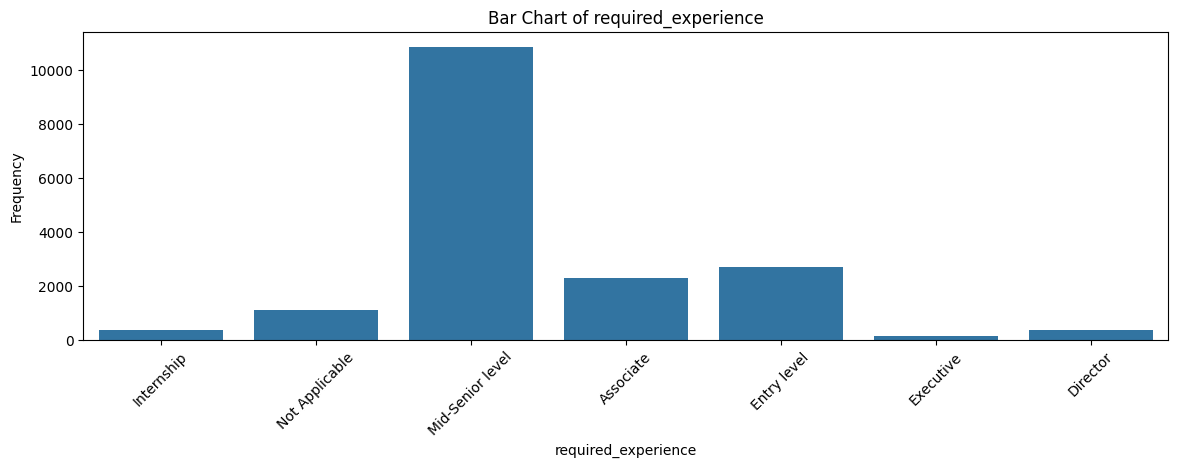

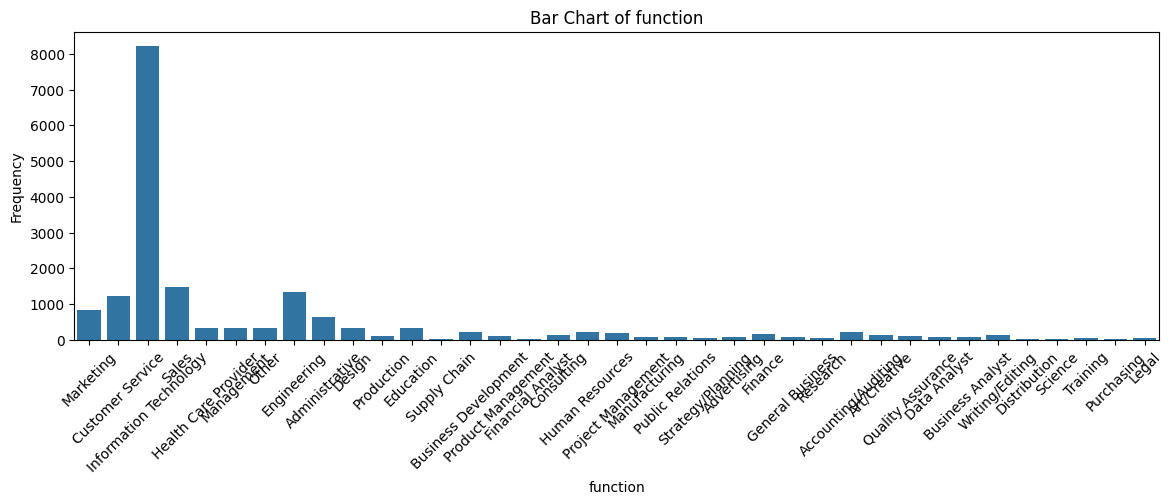

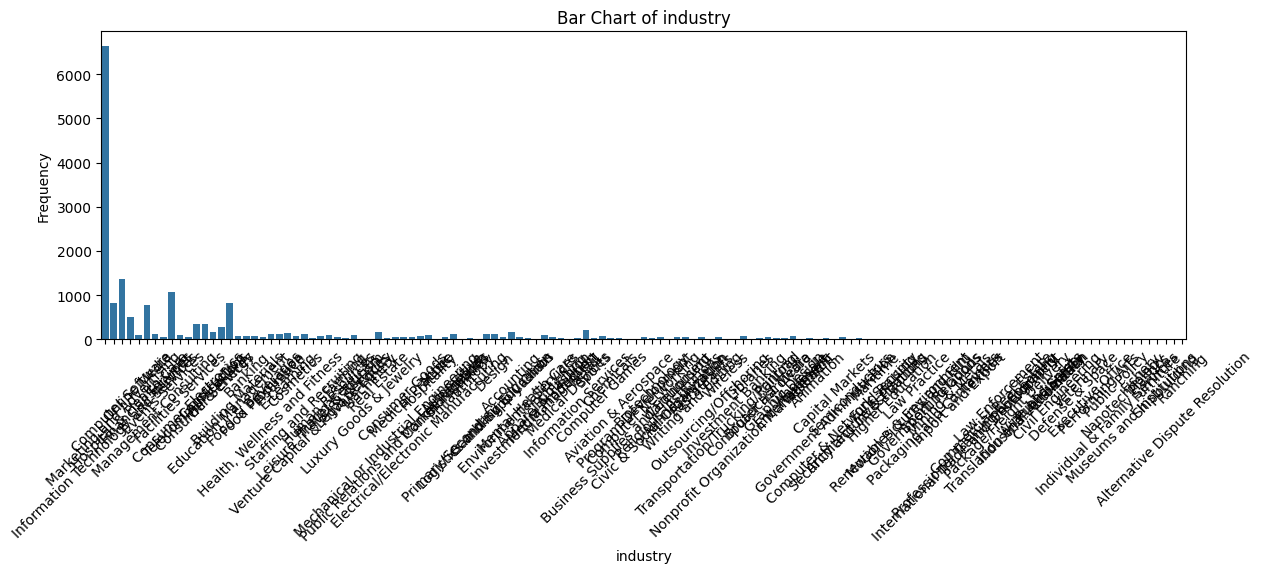

In [22]:
for col in categorical_columns:
    plt.figure(figsize=(14, 4))
    sns.countplot(x=df[col])
    plt.title(f'Bar Chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# 4. Feature Engineering & Transformation

In [23]:
#renaming the target variable
df = df.rename(columns={'fraudulent': 'fraudulent_target'})

In [24]:
df['description_length'] = df['description'].apply(len)
df['requirements_length'] = df['requirements'].apply(len)
df['benefits_length'] = df['benefits'].apply(len)

## 4.1 Encoding Categorical columns

In [25]:
for col in categorical_columns:
    if col == "employment_type":
        one_hot_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
        X_encoded = one_hot_encoder.fit_transform(df[[col]])
        df= df.drop(columns=[col])
        df = pd.concat([df, pd.DataFrame(X_encoded.toarray(), index=df.index,columns=one_hot_encoder.get_feature_names_out())], axis=1)
    elif col in ["required_experience", "required_education"]:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
    
    elif col in ["function", "industry"]:
        target_encoder = TargetEncoder()
        df[col] = target_encoder.fit_transform(df[col],df['fraudulent_target'])

## 4.2 TF_IDF Vectoristaion

In [26]:
def clean_text(text):
    """
    Cleans the input text by removing punctuation, converting to lowercase,
    and removing stop words.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    if isinstance(text, str):  # Check if the input is a string
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [w for w in tokens if not w in stop_words]
        return " ".join(tokens)
    else:
        return "" # Return empty string for non-string input

In [27]:
for col in text_columns:
    df[col] = df[col].apply(clean_text)

In [28]:
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row.values), axis=1)

In [29]:
# Vectorize the combined text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [30]:
# Concatenate TF-IDF features with the original dataframe
df = pd.concat([df, tfidf_df], axis=1)

In [31]:
# Drop the original text columns and the combined text column
df = df.drop(columns=text_columns + ['combined_text'])

In [32]:
print("\nData After Text Vectorization:")
df.head()


Data After Text Vectorization:


telecommuting  has_company_logo  has_questions  required_experience  \
0            0.0               1.0            0.0                    4   
1            0.0               1.0            0.0                    6   
2            0.0               1.0            0.0                    5   
3            0.0               1.0            0.0                    5   
4            0.0               1.0            1.0                    5   

   required_education  industry  function  fraudulent_target  \
0                   1  0.046256  0.012048                  0   
1                   1  0.054348  0.054516                  0   
2                   1  0.046256  0.044978                  0   
3                   1  0.003634  0.027929                  0   
4                   1  0.102616  0.002959                  0   

   description_length  requirements_length  ...  τις   το  τον  του  τους  \
0                 905                  852  ...  0.0  0.0  0.0  0.0   0.0   
1                2077                 1433  ...  0.0  0.0  0.0  0.0   0.0   
2                 355                 1363  ...  0.0  0.0  0.0  0.0   0.0   
3                2600                 1429  ...  0.0  0.0  0.0  0.0   0.0   
4                1520                  757  ...  0.0  0.0  0.0  0.0   0.0   

   των  χώρο  όπως  ότι  оптовых  
0  0.0   0.0   0.0  0.0      0.0  
1  0.0   0.0   0.0  0.0      0.0  
2  0.0   0.0   0.0  0.0      0.0  
3  0.0   0.0   0.0  0.0      0.0  
4  0.0   0.0   0.0  0.0      0.0  

[5 rows x 10011 columns]

# 5. Model Selection and Training

In [33]:
df.select_dtypes(include=['int64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   required_experience  17880 non-null  int64
 1   required_education   17880 non-null  int64
 2   fraudulent_target    17880 non-null  int64
 3   description_length   17880 non-null  int64
 4   requirements_length  17880 non-null  int64
 5   benefits_length      17880 non-null  int64
dtypes: int64(6)
memory usage: 838.3 KB


In [34]:
X = df.drop('fraudulent_target', axis=1)
y = df['fraudulent_target']

In [35]:
X.head()

telecommuting  has_company_logo  has_questions  required_experience  \
0            0.0               1.0            0.0                    4   
1            0.0               1.0            0.0                    6   
2            0.0               1.0            0.0                    5   
3            0.0               1.0            0.0                    5   
4            0.0               1.0            1.0                    5   

   required_education  industry  function  description_length  \
0                   1  0.046256  0.012048                 905   
1                   1  0.054348  0.054516                2077   
2                   1  0.046256  0.044978                 355   
3                   1  0.003634  0.027929                2600   
4                   1  0.102616  0.002959                1520   

   requirements_length  benefits_length  ...  τις   το  τον  του  τους  των  \
0                  852                7  ...  0.0  0.0  0.0  0.0   0.0  0.0   
1                 1433             1292  ...  0.0  0.0  0.0  0.0   0.0  0.0   
2                 1363                7  ...  0.0  0.0  0.0  0.0   0.0  0.0   
3                 1429              782  ...  0.0  0.0  0.0  0.0   0.0  0.0   
4                  757               21  ...  0.0  0.0  0.0  0.0   0.0  0.0   

   χώρο  όπως  ότι  оптовых  
0   0.0   0.0  0.0      0.0  
1   0.0   0.0  0.0      0.0  
2   0.0   0.0  0.0      0.0  
3   0.0   0.0  0.0      0.0  
4   0.0   0.0  0.0      0.0  

[5 rows x 10010 columns]

In [36]:
y

0        0
1        0
2        0
3        0
4        0
        ..
17875    0
17876    0
17877    0
17878    0
17879    0
Name: fraudulent_target, Length: 17880, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## LogisticRegression

In [38]:
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # Add class_weight

In [39]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
grid_search_lr = GridSearchCV(logistic_regression_model, param_grid_lr, cv=stratified_kfold, scoring='f1') 

In [40]:
grid_search_lr.fit(X_train, y_train) 
best_lr = grid_search_lr.best_estimator_

## RandomForest

In [41]:
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced') 

In [42]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=stratified_kfold, scoring='f1')  

In [43]:
grid_search_rf.fit(X_train, y_train) 
best_rf = grid_search_rf.best_estimator_

# 5. Model Performance Evaluation

In [44]:
def evaluate_model(model, X, y, model_name="Model"):
    """
    Evaluates the performance of a given model and prints various metrics.
    Also generates and displays the confusion matrix and ROC curve.

    Args:
        model: The trained machine learning model.
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target variable.
        model_name (str): Name of the model
        
    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    metrics = {
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1-score": f1_score(y, y_pred),
            "ROC-AUC": roc_auc_score(y, y_pred_proba),
            "Average Precision": average_precision_score(y, y_pred_proba)
        }


    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {metrics["Accuracy"]:.4f}")
    print(f"Precision: {metrics["Precision"]:.4f}")
    print(f"Recall: {metrics["Recall"]:.4f}")
    print(f"F1-score: {metrics["F1-score"]:.4f}")
    print(f"ROC-AUC: {metrics["ROC-AUC"]:.4f}")
    print(f"Average Precision: {metrics["Average Precision"]:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=["Real", "Fake"])
    confusion_matrix_display.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics["ROC-AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y, y_pred_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall_curve, precision_curve, color='b',label=f'{model_name} (AP = {metrics["Average Precision"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    return metrics #returning the predictions.


Logistic Regression Performance:
Accuracy: 0.9891
Precision: 0.8988
Recall: 0.8728
F1-score: 0.8856
ROC-AUC: 0.9944
Average Precision: 0.9450


<Figure size 600x500 with 0 Axes>

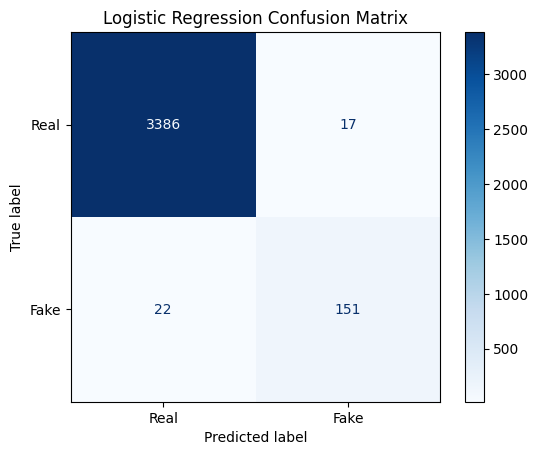

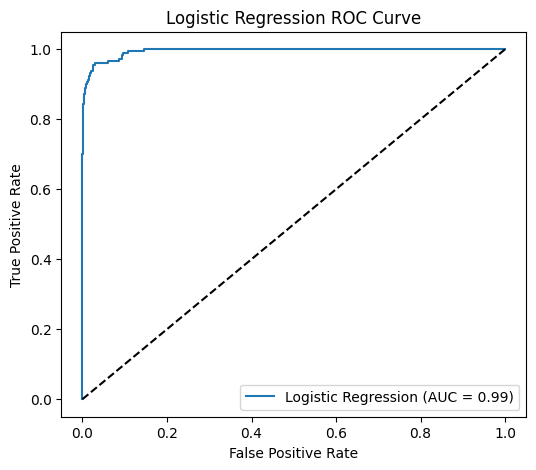

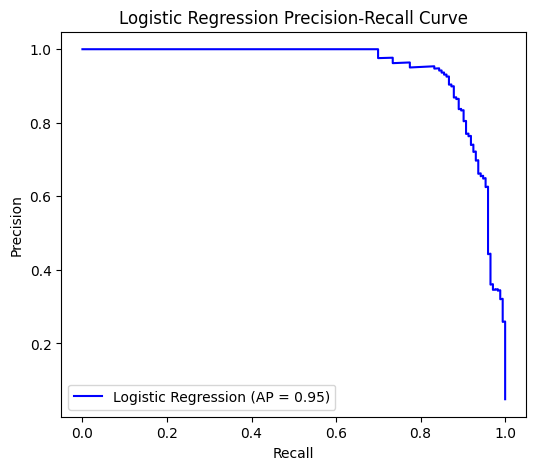

In [45]:
# Evaluate Logistic Regression
lr_metrics = evaluate_model(best_lr, X_test, y_test, "Logistic Regression")


Random Forest Performance:
Accuracy: 0.9793
Precision: 0.9901
Recall: 0.5780
F1-score: 0.7299
ROC-AUC: 0.9919
Average Precision: 0.9124


<Figure size 600x500 with 0 Axes>

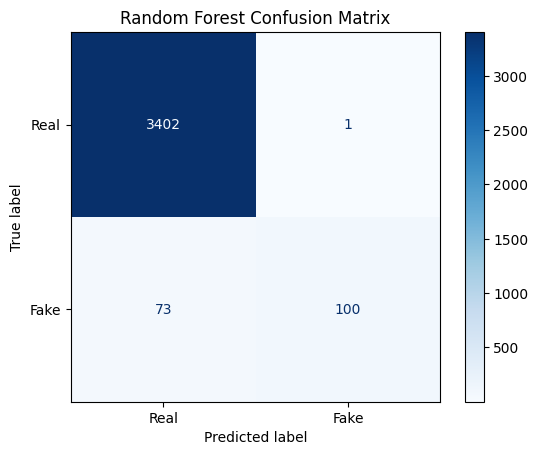

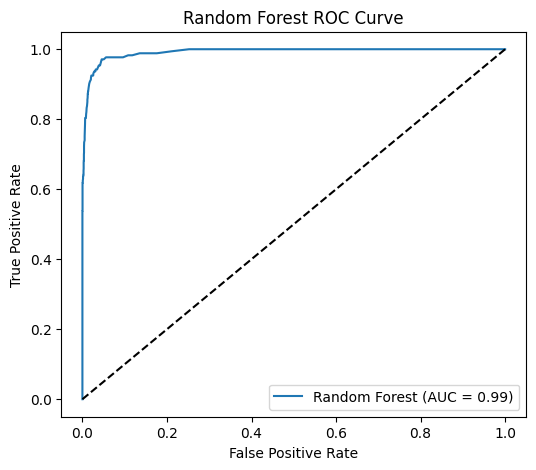

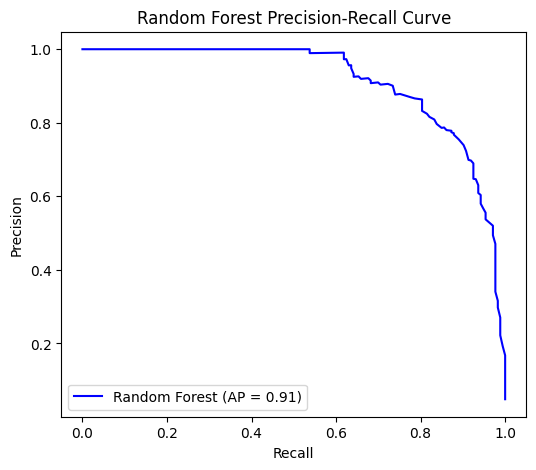

In [46]:
# Evaluate Random Forest
rf_metrics = evaluate_model(best_rf, X_test, y_test, "Random Forest")

In [47]:
feature_importance_rf = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_rf})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("\n--- Random Forest Feature Importance ---")
print(feature_importance_df.head(10))


--- Random Forest Feature Importance ---
               Feature  Importance
1     has_company_logo    0.025103
5             industry    0.020638
5651           missing    0.012398
6             function    0.011116
9696               web    0.009330
8791              team    0.008204
9417                us    0.006688
5287              love    0.006046
8152            skills    0.005565
5893               new    0.005300


# 6. Compare Model Results

In [48]:
# Compare overall performance (Accuracy, F1, AUC)
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Logistic Regression': [
        lr_metrics['Accuracy'],
        lr_metrics['Precision'],
        lr_metrics['Recall'],
        lr_metrics['F1-score'],
        lr_metrics['ROC-AUC']
    ],
    'Random Forest': [
        rf_metrics['Accuracy'],
        rf_metrics['Precision'],
        rf_metrics['Recall'],
        rf_metrics['F1-score'],
        rf_metrics['ROC-AUC']
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

      Metric  Logistic Regression  Random Forest
0   Accuracy             0.989094       0.979306
1  Precision             0.898810       0.990099
2     Recall             0.872832       0.578035
3   F1-score             0.885630       0.729927
4    ROC-AUC             0.994352       0.991884
